# Multi-Layer Perceptron Neural Network

**Due: Wednesday, 11/22/2023, 2:15 PM**

Welcome to your fourth assignment. You will build a multi-layer perceptron neural network in this assignment. The goal of building such a  is to classify hand-written digits.

## Exercises:
1. $\color{violet}{\textbf{(20\%) Data Preprocessing}}$
2. $\color{violet}{\textbf{(5\%) Logistic Regression Model}}$
3. $\color{violet}{\textbf{(5\%) Cross Entropy Loss}}$
4. $\color{violet}{\textbf{(40\%) Gradient Descent Optimization}}$
5. $\color{violet}{\textbf{(15\%) Evaluation on Test Dataset}}$
6. $\color{violet}{\textbf{(15\%) Test Model with New Image}}$

## Instructions:
- Write your code only between the $\color{green}{\textbf{\small \#\#\# START CODE HERE \#\#\#}}$ and $\color{green}{\textbf{\small \#\#\# END CODE HERE \#\#\#}}$ commented lines. $\color{red}{\textbf{Do not modify code out of the designated area.}}$
- Reference answers are provided after a certain coding blocks. Be aware if your answer is different from the reference..
- **Need to install [Torchvision](https://pytorch.org/vision/stable/index.html)**
    ```console
    pip install torchvision
    ```
**You will learn:**
- Usage of Rectified Linear Unit (ReLU) activation function.
- Generalize number and dimension of the hidden layers.



## Review

**NOTE: math representations of forward and backward propogation has been updated. Please use the equations in the [updated slides](https://linzhanguca.github.io/_docs/applied_deep_learning-2022/0921/nn_p2.pdf) or the follows if you prefer no transopose in the forward propagation.**

To build your neural network, you will complete several "helper functions". These helper functions will be used to realize the forward and backward propagation when training a K-layer neural network. Each small helper function you will implement will have detailed instructions that will walk you through the necessary steps. Here is an outline of this assignment, you will:

- Initialize the parameters for K-layer neural network.
- Implement the forward propagation. 
     - Compute linear transformation $\mathbf{Z}^{[k]} = \mathbf{X}^{[k-1]} \cdot \mathbf{W}^{[k]} + \mathbf{b}^{[k]}$.
     - Compute activation: $X^{[k]} = g(\mathbf{Z}^{[k]})$.
     - Stack the "linear transfortmation" and "activation" to compute predictions in the final layer.
- Compute the cross entropy loss: 
    $$\mathcal{L(\hat{\mathbf{y}}, \mathbf{y}) = \frac{1}{M}\sum_{i=1}^M (-\mathbf{y}log(\hat{\mathbf{y}}) - (1 - \mathbf{y})log(1 - \hat{\mathbf{y}}))}$$
- Compute gradients of the parameters for backward propagation.
    $$d\mathbf{Z}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{Z}^{[k]}}} = d\mathbf{X}^{[k]} * g'^{[k]}(\mathbf{Z}^{[k]})$$
    $$d\mathbf{W}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{W}^{[k]}}} = \frac{1}{M}\mathbf{X}^{[k-1]\mathbf{T}} \cdot d\mathbf{Z}^{[k]}$$
    $$d\mathbf{b}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{b}^{[k]}}} = \frac{1}{M} \Sigma d\mathbf{Z}^{[k]}$$
    $$d\mathbf{X}^{[k-1]} = \frac{\partial{J}}{\partial{\mathbf{X}^{[k-1]}}} = d\mathbf{Z}^{[k]} \cdot \mathbf{W}^{[k]\mathbf{T}}$$
- Update the parameters using gradient descent algorithm.

## 1. Load Dataset
Torchvision provides a descent pool of datasets. We'll load one of the built-in dataset, [FashionMNIST](https://pytorch.org/vision/stable/datasets.html) to investigate multi-class classification using a generic Multi-Layer Perceptron (MLP) model.

training feature array shape: (60000, 28, 28), test feature array shape: (10000, 28, 28)
training target array shape: (60000,), test target array shape: (10000,)
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


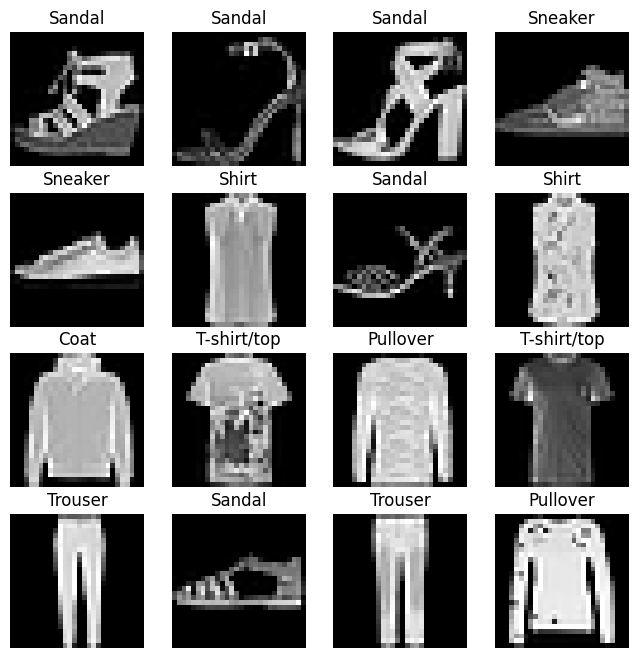

In [1]:
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
train_set = datasets.FashionMNIST('./data', train=True, download=True)
test_set = datasets.FashionMNIST('./data', train=False, download=True)

# Extract important arrays
train_feature_array = train_set.data.numpy()
train_target_array = train_set.targets.numpy()
test_feature_array = test_set.data.numpy()
test_target_array = test_set.targets.numpy()
category_keys = train_set.classes
category_vals = range(len(category_keys))
category_dict = dict((map(lambda i,j : (i,j), category_keys, category_vals)))

print(f"training feature array shape: {train_feature_array.shape}, test feature array shape: {test_feature_array.shape}")
print(f"training target array shape: {train_target_array.shape}, test target array shape: {test_target_array.shape}")
print(category_dict)

# Visualize
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(train_set))
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(category_keys[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")


## 2. Preprocess the Data
A $\mathcal{C}$-calss dataset with   is made up with a feature matrix: $\mathbf{X} = [^{(1)}\mathbf{x}, ^{(2)}\mathbf{x}, ..., ^{(M)}\mathbf{x}]^T$. and a one-hot encoded target matrix $\mathbf{Y} = [^{(1)}\mathbf{y}, ^{(2)}\mathbf{y}, ..., ^{(M)}\mathbf{y}]^T$. Where $M$ is the total number of instances in the dataset, $^{(m)}\mathbf{x} = [^{(m)}x_1, ..., ^{(m)}x_n]$ is a normalized and flattened row vector bears $n$ feature values, and $^{(m)}\mathbf{y} = [0, ..., 0, 1, 0, ..., 0]$ is a one-hot encoded row vector.

- A grey-scale image can be represented by a **2-dimensional array with shape $(width, height)$**. Where, $width$ indicates number of pixels on horizontal direction, $height$ indicates number of pixels on vertical direction.
- We can use an **integer ranged 0~255** to describe a pixel's color intensity. However, it is easier for your computer to handlle float values.
- We would like to convert an image array into a row vector, or a **2d array with shape $(1, width*height)$**. So that, we can stack these row vectors vertically to form a feature matrix.
- We also would like to encode target array into one-hot format.


We will access the raw data by extracting it from the dataloaders. Then, process and prepare the raw data so that it can be used in later steps.

### $\color{violet}{\textbf{(20\%) Exercise 1: Data Preprocessing}}$
1. Reshape feature array.
2. One-hot encode target array
3. Rescale feature arrary, represent each pixel with a float numbers in range 0~1. 

In [2]:
### START CODE HERE ### (≈ 10 lines of code)
M_train = train_target_array.shape[0]  # number of sampels in training data
M_test = test_target_array.shape[0]  # number of samples in test data
# Reshape feature and target arrays
flatten_feature_train = train_feature_array.reshape(M_train, -1)  # (60000, 28, 28) -> (60000, 1)
flatten_feature_test = test_feature_array.reshape(M_test, -1)  # (10000, 28, 28) -> (10000, 1)
# One hot encode targets
onehot_target_train = np.zeros((M_train, len(category_dict)))
onehot_target_train[np.arange(M_train), train_target_array] = 1
onehot_target_test = np.zeros((M_test, len(category_dict)))
onehot_target_test[np.arange(M_test), test_target_array] = 1
# print(np.sum(onehot_target_test, axis=0))
# Rescale features
rescale_feature_train = flatten_feature_train / 255
rescale_feature_test = flatten_feature_test / 255
### END CODE HERE ###

# Rename
feature_train = rescale_feature_train
feature_test = rescale_feature_test
target_train = onehot_target_train
target_test = onehot_target_test
print(f"training feature shape: {feature_train.shape}, test feature shape: {feature_test.shape}, training target shape: {target_train.shape}, test target shape: {target_test.shape}")
print(f"sample feature portion: \n{feature_train[3321][350:400]}")
print(f"sample target: \n{target_train[3321]}")


training feature shape: (60000, 784), test feature shape: (10000, 784), training target shape: (60000, 10), test target shape: (10000, 10)
sample feature portion: 
[0.99607843 0.79215686 0.82745098 0.79215686 0.79607843 0.79215686
 0.83921569 0.84313725 0.83921569 0.84705882 0.82352941 0.92941176
 0.57254902 0.         0.00392157 0.         0.         0.
 0.         0.         0.00784314 0.01568627 0.01176471 0.
 0.         0.         0.38039216 0.98823529 0.80784314 0.83529412
 0.80392157 0.81176471 0.8        0.80784314 0.83529412 0.83921569
 0.84313725 0.84705882 0.85490196 0.90980392 0.77254902 0.
 0.         0.00784314 0.01960784 0.02745098 0.00784314 0.00392157
 0.         0.        ]
sample target: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


**Expected Output**:
>
```console
training feature shape: (60000, 784), test feature shape: (10000, 784), training target shape: (60000, 10), test target shape: (10000, 10)
sample feature portion: 
[0.99607843 0.79215686 0.82745098 0.79215686 0.79607843 0.79215686
 0.83921569 0.84313725 0.83921569 0.84705882 0.82352941 0.92941176
 0.57254902 0.         0.00392157 0.         0.         0.
 0.         0.         0.00784314 0.01568627 0.01176471 0.
 0.         0.         0.38039216 0.98823529 0.80784314 0.83529412
 0.80392157 0.81176471 0.8        0.80784314 0.83529412 0.83921569
 0.84313725 0.84705882 0.85490196 0.90980392 0.77254902 0.
 0.         0.00784314 0.01960784 0.02745098 0.00784314 0.00392157
 0.         0.        ]
sample target: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
```

## 2. Forward Pass
A Multi-Layer Perceptron (MLP) model is featured with multiple layers of transformed features. Any two adjacent layer are connected by a linear model and an activation function. The linear model is governed by a set of weight parameters and a set of bias parameters. The general structure of an MLP model is shown below.
![](./model.png)

### 2.1. Initialize Parameters
A linear model governed by weights $\mathbf{W}^{[l]}$ and $\mathbf{b}^{[l]}$ transforms features, $\mathbf{X}^{[l-1]}$ in the $l-1$-th layer to $\mathbf{Z}^{[l]}$ in the $l$-th layer.

$\mathbf{Z}^{[l]} = \mathbf{X}^{[l-1]} \cdot \mathbf{W}^{[l]T} + \mathbf{b}^{[l]}$

Assume $\mathbf{X}^{[l-1]}$ has $N_{l-1}$ features and $\mathbf{X}^{[l]}$ has $N_{l}$ features, then $\mathbf{W}^{[l]}$ is with shape $(N_l, N_{l-1})$, $\mathbf{b}^{[l]}$ is with shape $(1, N_l)$

### $\color{violet}{\textbf{(10\%) Exercise 2: Parameter Initialization}}$
Define a function to initialize weights and biases parameters and save these parameters in a **dictionary**. 
- Input sizes of all the layers (**include the input layer**) using a **list**.
- Use a **`for` loop** to randomly initialize $\mathbf{W}^{[l]}$ and $\mathbf{b}^{[l]}$ for the $l$-th layer.


In [5]:
def init_params(layer_sizes):
    """ Parameter initialization function
    Args:
        layer_sizes -- list/tuple, (input size, ..., hidden layer size, ..., output size)
    Returns:
        parameters -- dictionary, contains parameters: Wi and bi, i is the i-th layer
    """
    parameters = {}
    ### START CODE HERE ### (≈ 2 lines of code)
    for i in range(len(layer_sizes) - 1):
        parameters['W'+str(i+1)] = np.random.normal(0, 0.0001, size=(layer_sizes[i+1], layer_sizes[i]))
        parameters['b'+str(i+1)] = np.random.normal(0, 0.0001, size=(1, layer_sizes[i+1]))
    ### END CODE HERE ###

    return parameters

# Sanity check
np.random.seed(3321)
dummy_layer_sizes = (6, 5, 4, 3)  # (input size, layer1 size, layer2 size, output size)
dummy_params = init_params(dummy_layer_sizes)
print(dummy_params.keys())
print(dummy_params)


dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
{'W1': array([[ 3.68455981e-05, -1.38782645e-04, -7.23142013e-05,
         9.20641119e-05, -1.95355264e-05,  3.87255258e-05],
       [-6.00629078e-05,  3.25435259e-06,  6.46665063e-05,
        -7.84748031e-05,  1.41884652e-04, -6.15479349e-05],
       [-1.10127440e-04, -6.82385574e-05,  7.96622349e-05,
         5.25934678e-05, -1.78411966e-04,  1.28629057e-04],
       [ 5.66879246e-05,  8.95999019e-05, -1.62874713e-05,
         3.51109174e-05, -1.03338181e-04, -8.88623865e-05],
       [ 5.10860443e-05,  1.19661547e-04,  8.64757553e-05,
        -1.41101724e-04,  1.38003186e-04, -1.06812125e-04]]), 'b1': array([[ 6.38004843e-05, -6.19666755e-05,  1.12931166e-04,
        -3.12290798e-05,  5.59708416e-05]]), 'W2': array([[ 1.02685210e-04, -1.28307992e-04, -4.03018811e-05,
        -4.09270011e-05, -1.84834135e-05],
       [ 1.71466862e-04, -9.69611346e-05,  4.40873689e-05,
        -1.10516782e-04, -5.17959570e-05],
       [-1.87055902e-04, -6.

**Expected Output**:
>
```console
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
{'W1': array([[ 3.68455981e-05, -1.38782645e-04, -7.23142013e-05,
         9.20641119e-05, -1.95355264e-05,  3.87255258e-05],
       [-6.00629078e-05,  3.25435259e-06,  6.46665063e-05,
        -7.84748031e-05,  1.41884652e-04, -6.15479349e-05],
       [-1.10127440e-04, -6.82385574e-05,  7.96622349e-05,
         5.25934678e-05, -1.78411966e-04,  1.28629057e-04],
       [ 5.66879246e-05,  8.95999019e-05, -1.62874713e-05,
         3.51109174e-05, -1.03338181e-04, -8.88623865e-05],
       [ 5.10860443e-05,  1.19661547e-04,  8.64757553e-05,
        -1.41101724e-04,  1.38003186e-04, -1.06812125e-04]]), 'b1': array([[ 6.38004843e-05, -6.19666755e-05,  1.12931166e-04,
        -3.12290798e-05,  5.59708416e-05]]), 'W2': array([[ 1.02685210e-04, -1.28307992e-04, -4.03018811e-05,
        -4.09270011e-05, -1.84834135e-05],
       [ 1.71466862e-04, -9.69611346e-05,  4.40873689e-05,
        -1.10516782e-04, -5.17959570e-05],
       [-1.87055902e-04, -6.31341925e-05, -5.47992268e-05,
         3.67804566e-05, -1.05795654e-04],
       [ 1.24964681e-04,  3.60854003e-05,  1.30113815e-04,
         1.01177937e-04,  2.22286230e-05]]), 'b2': array([[ 1.16709537e-04, -1.12496462e-04, -9.47925077e-05,
        -4.49789001e-05]]), 'W3': array([[ 1.01049508e-04, -3.52965408e-05,  2.06672986e-04,
        -1.67359842e-05],
       [-7.34788781e-05,  1.28189925e-05,  3.67334763e-05,
        -3.00482492e-05],
       [ 9.36343566e-05, -3.80351405e-05,  6.59823461e-06,
         5.61206851e-05]]), 'b3': array([[ 2.57409859e-04,  1.69968799e-05, -7.22321090e-05]])}
```

### 2.2 - Forward Propagation
A linear model transforms features, $\mathbf{X}^{[l-1]}$ in the $l-1$-th layer to $\mathbf{Z}^{[l]}$ in the $l$-th layer. Then we apply a Linear Rectified Unit (ReLU) function on $\mathbf{Z}^{[l]}$ to form new features $\mathbf{Z}^{[l]}$ in the $l$-th layer.

$$\mathbf{Z}^{[l]} = \mathbf{X}^{[l-1]} \cdot \mathbf{W}^{[l]T} + \mathbf{b}^{[l]}$$

$$\mathbf{X}^{[l]} = ReLU(\mathbf{Z}^{[l]}) = 
    \begin{cases}
        0   & z \leq 0 \\
        z   & z > 0
    \end{cases}
$$

The last layer needs to be activcated by a softmax function.

#### $$\hat{y}_i = \frac{e^{z^{[L]}_i}}{\sum^C_{i=1} e^{z^{[L]}_i}}$$

The maxtrix $\mathbf{Z}^{[L]}$ has shape: $(M, C)$, where $M$ is the number of samples, $C$ is the number of classes. When applying softmax activation, we only want to apply it on the 2nd dimension (1st axis in numpy). So that each row in $\mathbf{Z}^{[L]}$ will be converted to probabilities.
### $\color{violet}{\textbf{(40\%) Exercise 3: Linear Model and Activation}}$
- Define ReLU activation function and softmax activation function.
- Define linear model.
- Define forward propagation process.


In [11]:
### START CODE HERE ### (≈ 6 lines of code)
def relu(x):
    """ Rectified linear unit function
    Args:
        x -- scalar/array
    Returns:
        y -- scalar/array, 0 if x <= 0, x if x >0
    """
    y = np.maximum(0, x)

    return y

def softmax(x):
    """ Softmax function
    Args:
        x -- array
    Returns:
        prob -- array
    """
    prob = np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)
    
    return prob

def linear(feature, weight, bias):
    """ Linear model
    Args:
        feature (matrix): 2d array with shape (M, N^[l-1])
        weight (matrix): 2d array with shape (N^[l], N^[l-1])
        bias (row vector): 2d array with shape (1, N^[l])
    Returns:
        Z (matrix): 2d array with shape (M, , N^[l])
    """
    Z = np.dot(feature, weight.T) + bias
        
    return Z

def forward(input_feature, params):
    """ Forward propagation process
    Args:
        input_feature (matrix): 2d array with shape (M, N^[0])
        params: dictionary, stores W's and b's
    Returns:
        prediction: 2d array with shape (M, C)
        cache: dictionary, stores intemediate X's and Z's.
    """
    cache = {'X0': input_feature}
    for i in range(int(len(params) / 2) - 1):
        cache['Z' + str(i+1)] = linear(cache['X' + str(i)], params['W' + str(i+1)], params['b' + str(i+1)])
        cache['X' + str(i+1)] = relu(cache['Z' + str(i+1)])
    cache['Z' + str(i+2)] = linear(cache['X' + str(i+1)], params['W' + str(i+2)], params['b' + str(i+2)])
    prediction = softmax(cache['Z' + str(i+2)])

    return prediction, cache
### END CODE HERE ###

# Sanity check
np.random.seed(3321)
dummy_input = np.random.randn(8,6)
dummy_pred, dummy_cache = forward(dummy_input, dummy_params)
print(dummy_pred)
print(f"cache dictionary keys: {dummy_cache.keys()}")

[[0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]]
cache dictionary keys: dict_keys(['X0', 'Z1', 'X1', 'Z2', 'X2', 'Z3'])


**Expected Output**:
>
```console
[[0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]]
cache dictionary keys: dict_keys(['X0', 'Z1', 'X1', 'Z2', 'X2', 'Z3'])
```

## 3. Multi-Class Cross Entropy Loss
For multi-class classification problem, it is quite standard to use a general form of cross entropy function to evaluate model prediction vs. target. 
#### $\mathcal{L}(\mathbf{\hat{Y}}, \mathbf{Y}) = -\frac{1}{M} \sum_{m=1}^M \sum_{c=1}^C {^{(m)} y_c} \log {^{(m)} \hat{y}_c}$

### $\color{violet}{\textbf{(5\%) Exercise 4: Cross Entropy Loss}}$
Define a cross entropy function to compute the average loss between prediction matrix and target matrix. 


In [25]:
### START CODE HERE ### (≈ 1 lines of code)
def cross_entropy_loss_fn(prediction, target):
    """ Cross entropy loss function
    Args:
        prediction (matrix): 2d array with shape (M, C)
        target (matrix): 2d array with shape (M, C)
    Returns:
        loss_value: scalar, averaged ce loss
    """
    loss_value = -np.sum(target * np.log(prediction + 1e-10), axis=1)

    return loss_value.mean()
### END CODE HERE ###

# Sanity check
dummy_target = np.zeros((8, 3))
dummy_target[np.arange(8), np.random.randint(0, 3, (8,))] = 1
dummy_loss = cross_entropy_loss_fn(dummy_pred, dummy_target)
print(dummy_loss)

1.098605997066486


## 4. Back-Propagation
In order to know how to update weights and biases, we need to compute the gradient of the loss. This requires compute gradient of loss w.r.t. the variables in the last layer first. Then compute gradient of loss w.r.t. the variables in the previous layer next. And so on, until the gradient of loss w.r.t. the first layer is computed. 

Due to the fact that the last layer is softmax activated, $\frac{\partial \mathcal{L}}{\partial \mathbf{Z}^{[L]}}$ can be computed differently without explicitly solve for derivative of softmax function.
$$d\mathbf{Z}^{[L]} = \frac{\partial \mathcal{L}}{\partial \mathbf{Z}^{[L]}} = \mathbf{\hat{Y}} - \mathbf{Y} $$

Then, from last layer $L$ to first layer, we need to repeatedly computing the gradient of loss according to the chain rule. The computation of a general layer $[l]$ is as follows.
$$d\mathbf{W}^{[l]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{W}^{[l]}}} = d\mathbf{Z}^{[l]T} \cdot \mathbf{X}^{[l-1]}$$
$$d\mathbf{b}^{[l]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{b}^{[l]}}} = mean(d\mathbf{Z}^{[l]}, axis=0, keepdims=True)$$
$$d\mathbf{X}^{[l-1]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{X}^{[l-1]}}} = d\mathbf{Z}^{[l]} \cdot \mathbf{W}^{[l]}$$
$$d\mathbf{Z}^{[l-1]} = d\mathbf{X}^{[l-1]} * relu'(\mathbf{Z}^{[l-1]})$$


### $\color{violet}{\textbf{(30\%) Exercise 5: Gradient Computation}}$
- Define derivative of ReLU function.
- Define a function to perform backward propagation to compute gradient of the (cross entropy) loss

In [21]:
### START CODE HERE ### (≈ 6 lines of code)
def d_relu(x):
    """ Rectified linear unit function
    Args:
        x -- scalar/array
    Returns:
        y -- scalar/array, 0 if x <= 0, x if x >0
    """
    dydx = np.ones_like(x)
    dydx[x < 0] = 0
    return dydx

def grad(prediction, target, params, cache):
    """ Backward propogating gradient computation
    Args:
        prediction (matrix): 2d array with shape (M, C)
        target (matrix): 2d array with shape (M, C)
        params: dictionary, stores W's and b's.
        cache: dictionary, stores intemediate X's and Z's.
    Returns:
        grads -- dictionary, stores dW's and db's
    """
    num_layers = int(len(params) / 2)
    grads = {'dZ' + str(num_layers): prediction - target}
    for i in reversed(range(num_layers)):
        grads['dW'+ str(i+1)] = np.dot(grads['dZ' + str(i+1)].T, cache['X' + str(i)])
        grads['db' + str(i+1)] = np.mean(grads['dZ' + str(i+1)], axis=0, keepdims=True)
        if not i:
            break
        grads['dX' + str(i)] = np.dot(grads['dZ' + str(i+1)], params['W' + str(i+1)])
        grads['dZ' + str(i)] =  grads['dX' + str(i)] * d_relu(cache['Z' + str(i)])
    return grads
### END CODE HERE ###

# Sanity check
dummy_grads = grad(dummy_pred, dummy_target, dummy_params, dummy_cache)
print(dummy_grads.keys())
print(dummy_grads)

dict_keys(['dZ3', 'dW3', 'db3', 'dX2', 'dZ2', 'dW2', 'db2', 'dX1', 'dZ1', 'dW1', 'db1'])
{'dZ3': array([[ 0.33339668, -0.66668347,  0.33328679],
       [ 0.33339668,  0.33331653, -0.66671321],
       [-0.66660332,  0.33331653,  0.33328679],
       [ 0.33339668, -0.66668347,  0.33328679],
       [ 0.33339668, -0.66668347,  0.33328679],
       [-0.66660332,  0.33331653,  0.33328679],
       [ 0.33339668,  0.33331653, -0.66671321],
       [ 0.33339668,  0.33331653, -0.66671321]]), 'dW3': array([[ 7.78342782e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.89266269e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.89076513e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]]), 'db3': array([[ 0.08339668, -0.04168347, -0.04171321]]), 'dX2': array([[ 1.13883818e-04, -3.29905699e-05,  4.66135899e-05,
         3.31572328e-05],
       [-5.32294163e-05,  1.78635631e-05,  7.67488316e-05,
        -5.30117015e-05],
       [-6.06445677

## 5. Optimization
We have been able to compute the gradient of the cross entropy loss. Now, it's time to perform gradient descent optimization to bring the loss down.

![](./gradient_dscent.png)


### $\color{violet}{\textbf{(30\%) Exercise 6: Gradient Descent Optimization}}$
Train your model with a `for` loop. Bring both training loss and test loss down.


Iteration 1 training loss: 2.3025851693967514, test loss: 2.302585175105499
Iteration 2 training loss: 2.3025849997037455, test loss: 2.3025850059359048
Iteration 3 training loss: 2.302584828591234, test loss: 2.302584835230665
Iteration 4 training loss: 2.302584655002608, test loss: 2.3025846619916694
Iteration 5 training loss: 2.302584477015182, test loss: 2.302584484428183
Iteration 6 training loss: 2.3025842920736235, test loss: 2.302584299861787
Iteration 7 training loss: 2.302584097355924, test loss: 2.3025841055254923
Iteration 8 training loss: 2.3025838901102067, test loss: 2.302583898736851
Iteration 9 training loss: 2.3025836677015192, test loss: 2.3025836769213464
Iteration 10 training loss: 2.3025834277149646, test loss: 2.302583437728197
Iteration 11 training loss: 2.302583167507992, test loss: 2.3025831785847455
Iteration 12 training loss: 2.3025828839330864, test loss: 2.3025828963025146
Iteration 13 training loss: 2.3025825733535963, test loss: 2.3025825870597947
Iterat

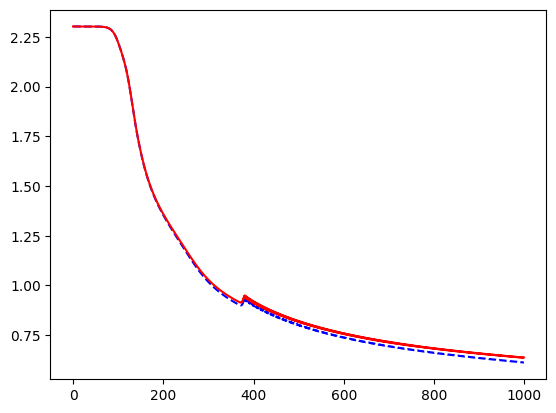

In [38]:
layer_sizes = [feature_train.shape[1], 128, 10]
params = init_params(layer_sizes)
num_iters = 1000
learning_rate = 1e-6
losses_train, losses_test = [], []
# Optimization loop
for i in range(num_iters):
    pred_train, cache = forward(feature_train, params)
    pred_test, _ = forward(feature_test, params)
    grads = grad(pred_train, target_train, params, cache)
    loss_train = cross_entropy_loss_fn(pred_train, target_train)
    loss_test = cross_entropy_loss_fn(pred_test, target_test)
    for j in range(len(layer_sizes) -1):
        params['W'+str(j+1)] = params['W'+str(j+1)] - learning_rate * grads['dW'+str(j+1)]
        params['b'+str(j+1)] = params['b'+str(j+1)] - learning_rate * grads['db'+str(j+1)]
    print(f"Iteration {i+1} training loss: {loss_train}, test loss: {loss_test}")
    losses_train.append(loss_train)
    losses_test.append(loss_test)

plt.plot(range(num_iters), losses_train, 'b--', range(num_iters), losses_test, 'r')



## Congrats on finishing this assignment! 